In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

In [109]:
df = pd.read_csv('data/skygeni_sales_data.csv')
df.sample(5)

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
3175,D03176,2024-01-06,2024-02-22,rep_2,Ecommerce,North America,Pro,Referral,Negotiation,77229,47,Won
1236,D01237,2024-03-22,2024-06-24,rep_23,HealthTech,Europe,Pro,Inbound,Negotiation,6912,94,Lost
2588,D02589,2024-01-24,2024-04-09,rep_13,Ecommerce,North America,Enterprise,Partner,Negotiation,3761,76,Lost
1891,D01892,2023-04-29,2023-07-07,rep_7,Ecommerce,North America,Core,Outbound,Closed,2248,69,Lost
1047,D01048,2023-04-29,2023-07-30,rep_1,SaaS,North America,Enterprise,Outbound,Demo,92373,92,Won


## 0. Feature Engineering

In [111]:
df["created_date"] = pd.to_datetime(df["created_date"])
df["closed_date"] = pd.to_datetime(df["closed_date"])

df["created_month"] = df["created_date"].dt.month
df["created_quarter"] = df["created_date"].dt.quarter
df["created_year"] = df["created_date"].dt.year
df['created_year_and_quarter'] = df["created_date"].dt.to_period("Q").astype(str)
df["created_weekday"] = df["created_date"].dt.weekday

df["closed_month"] = df["closed_date"].dt.month
df["closed_quarter"] = df["closed_date"].dt.quarter
df["closed_year"] = df["closed_date"].dt.year
df['closed_year_and_quarter'] = df["closed_date"].dt.to_period("Q").astype(str)
df["closed_weekday"] = df["closed_date"].dt.weekday

# Filter out the last quarter
latest_quarter = df['closed_year_and_quarter'].max()
df = df[df['closed_year_and_quarter'] != latest_quarter].copy()

# Time buckets (helps CRO thinking)
df["sales_cycle_bucket"] = pd.cut(
    df["sales_cycle_days"],
    bins=[0, 14, 30, 60, 90, np.inf],
    labels=["<2w", "2-4w", "1-2m", "2-3m", "3m+"]
)

# Binary outcome
df["is_won"] = (df["outcome"] == "Won").astype(int)

# ACV buckets (very important) --> Right skewed data, hence log transformed
df["acv_bucket"] = pd.qcut(
    df["deal_amount"], 
    # np.log1p(df["deal_amount"]), 
    q=4,
    labels=["Low", "Mid", "High", "Very High"]
)

# doesn't matter if I apply log or not in pd.qcut as log is a monotonic function (preserves order) 
# and qcut works by splitting thr ranked data into equal sized groups
# hence ranking order of values doesn't change post log applying
# NOTE: for strictly qcut into bucket applications, skip applying log as it is just additional compute, 
# look at examples/qcut-example.ipynb for sanity check

## 1. Time Based Analysis

In [120]:
# Group by quarter
quarterly_metrics = df.groupby('closed_year_and_quarter').agg(
    total_deals=('deal_id', 'count'),
    won_deals=('is_won', 'sum'),
    # won_deals=('outcome', lambda x: (x == 'won').sum()),
    total_acv=('deal_amount', 'sum'),
    mean_acv=('deal_amount', 'mean')
    mean_acv=('deal_amount', 'mean')
).reset_index()

# Calculate win rate
quarterly_metrics['win_rate'] = quarterly_metrics['won_deals'] / quarterly_metrics['total_deals'] * 100

quarterly_metrics


,closed_year_and_quarter,total_deals,won_deals,total_acv,mean_acv,median_acv,win_rate
0,2023Q1,328,146,7689967,23445.021341,13175.0,44.512195
1,2023Q2,973,438,24880389,25570.800617,13402.0,45.015416
2,2023Q3,1016,435,27899635,27460.270669,14888.5,42.814961
3,2023Q4,1027,488,26799813,26095.241480,13736.0,47.517040
4,2024Q1,990,462,26413879,26680.685859,14333.5,46.666667
5,2024Q2,637,279,17009398,26702.351648,14880.0,43.799058


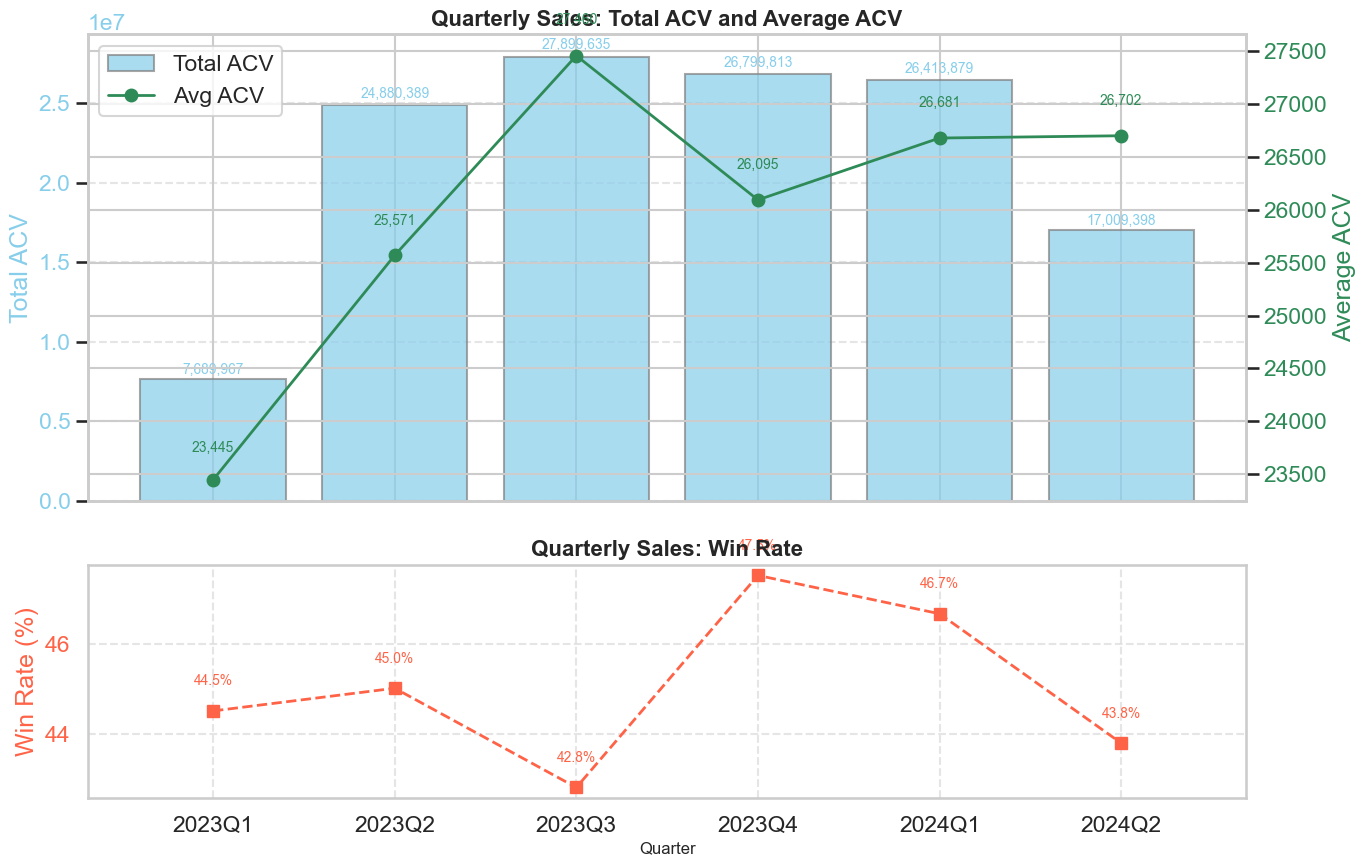

In [130]:
# Optional: use seaborn style for prettier plots
sns.set_style("whitegrid")
sns.set_context("talk")  # larger fonts

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14, 9), sharex=True, gridspec_kw={'height_ratios': [2, 1]}
)

# --- Top Pane: Total ACV (bar) + Avg ACV (line) ---
bar_color = '#87CEEB'  # skyblue
line_color = '#2E8B57'  # sea green

ax1.bar(
    quarterly_metrics['closed_year_and_quarter'],
    quarterly_metrics['total_acv'],
    color=bar_color,
    alpha=0.7,
    label='Total ACV',
    edgecolor='grey'
)
ax1.set_ylabel('Total ACV', color=bar_color)
ax1.tick_params(axis='y', labelcolor=bar_color)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Data labels for bars
for i, (x, y) in enumerate(zip(quarterly_metrics['closed_year_and_quarter'], quarterly_metrics['total_acv'])):
    ax1.text(i, y * 1.01, f'{y:,.0f}', ha='center', va='bottom', fontsize=10, color=bar_color)

# Line for average ACV
ax1_line = ax1.twinx()
ax1_line.plot(
    quarterly_metrics['closed_year_and_quarter'],
    quarterly_metrics['mean_acv'],
    color=line_color,
    marker='o',
    linewidth=2,
    label='Avg ACV'
)
ax1_line.set_ylabel('Average ACV', color=line_color)
ax1_line.tick_params(axis='y', labelcolor=line_color)

# Data labels for line
for i, (x, y) in enumerate(zip(quarterly_metrics['closed_year_and_quarter'], quarterly_metrics['mean_acv'])):
    ax1_line.text(i, y * 1.01, f'{y:,.0f}', ha='center', va='bottom', fontsize=10, color=line_color)

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_line.get_legend_handles_labels()
ax1_line.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True, facecolor='white')

ax1.set_title('Quarterly Sales: Total ACV and Average ACV', fontsize=16, weight='bold')

# --- Bottom Pane: Win Rate ---
win_rate_color = '#FF6347'  # tomato red
ax2.plot(
    quarterly_metrics['closed_year_and_quarter'],
    quarterly_metrics['win_rate'],
    color=win_rate_color,
    marker='s',
    linestyle='--',
    linewidth=2,
    markersize=8,
    label='Win Rate (%)'
)
ax2.set_ylabel('Win Rate (%)', color=win_rate_color)
ax2.tick_params(axis='y', labelcolor=win_rate_color)
ax2.grid(True, linestyle='--', alpha=0.5)

# Data labels for win rate
for i, (x, y) in enumerate(zip(quarterly_metrics['closed_year_and_quarter'], quarterly_metrics['win_rate'])):
    ax2.text(i, y + 0.5, f'{y:.1f}%', ha='center', va='bottom', fontsize=10, color=win_rate_color)

ax2.set_xlabel('Quarter', fontsize=12)
ax2.set_title('Quarterly Sales: Win Rate', fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [133]:
# Group by quarter
deals_opened_each_quarter = df.groupby('created_year_and_quarter').agg(
    deals_opened=('deal_id', 'count')
).reset_index()

deals_opened_each_quarter

,created_year_and_quarter,deals_opened
0,2023Q1,1006
1,2023Q2,1014
2,2023Q3,1006
3,2023Q4,1013
4,2024Q1,932


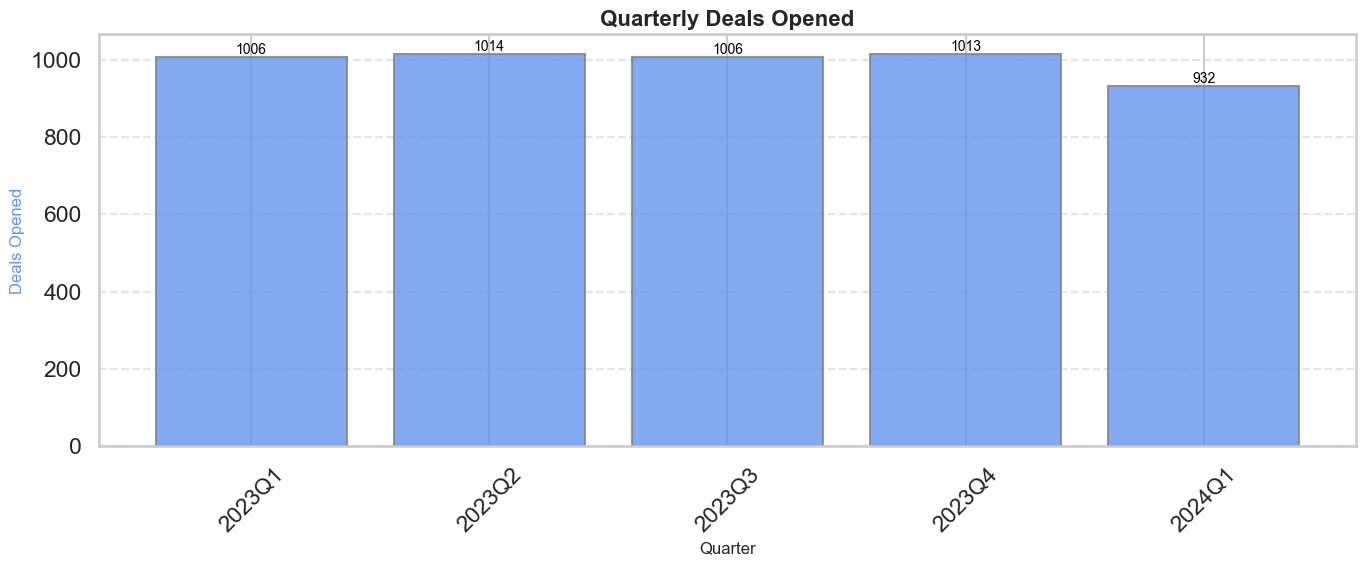

In [134]:
# Optional: prettier style
sns.set_style("whitegrid")
sns.set_context("talk")  # bigger fonts

fig, ax = plt.subplots(figsize=(14,6))

# Bar chart for deals opened
bar_color = '#6495ED'  # cornflower blue
ax.bar(
    deals_opened_each_quarter['created_year_and_quarter'],
    deals_opened_each_quarter['deals_opened'],
    color=bar_color,
    alpha=0.8,
    edgecolor='grey'
)

# Add data labels
for i, (x, y) in enumerate(zip(deals_opened_each_quarter['created_year_and_quarter'], deals_opened_each_quarter['deals_opened'])):
    ax.text(i, y + 0.5, f'{y}', ha='center', va='bottom', fontsize=10, color='black')

# Labels, title, grid
ax.set_ylabel('Deals Opened', fontsize=12, color=bar_color)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Quarterly Deals Opened', fontsize=16, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Win Rate Leakage is via Segment Level (not global)
### It is also to worth noting that in some cases win_rate does not proportionally affect revenues
#### While still causing damage in sales and business development effort, revenue is being upholded in certain manner 

### Introducing custom Metric: Expected Revenue per Opportunity = Win Rate × Average ACV

#### What It Rells You
1. Combines Conversion + Deal Size: shows true **monetization efficiency of pipeline**.
2. Better Market / Industry Comparison
3. Identifies Hidden Strength 

#### What It Does NOT Tell You
1. It ignores volume (number of opportunities).  
2. It does not measure sales cycle length.  
3. It doesn’t show total revenue impact (for that you'd multiply by opportunity count).  


#### Use It For:
1. Market prioritization  
2. Industry focus decisions  
3. Sales strategy comparison  
4. Early signal of monetization strength  

#### Avoid Using It Alone For:
1. Forecasting total revenue  
2. Capacity planning  

In [96]:
def win_rate_by_segment(df, col, n_quarters=3):
    """
    Aggregates win rate, successful deals, and average ACV for the last n quarters
    by a given segment column.

    Parameters:
    - df: DataFrame with at least 'closed_year_and_quarter', 'is_won', and 'deal_amount'
    - col: categorical column to group by (e.g., 'region', 'industry')
    - n_quarters: number of most recent quarters to include (default=3)
    
    Returns:
    - DataFrame grouped by ['closed_year_and_quarter', col] with metrics
    """
    # Get last n quarters
    last_n_quarters = (
        df["closed_year_and_quarter"]
        .sort_values()
        .unique()[-n_quarters:]
    )

    df_lastn = df[df["closed_year_and_quarter"].isin(last_n_quarters)]

    return (
        df_lastn.groupby(["closed_year_and_quarter", col])
        .agg(
            succesful_deals=("is_won", "sum"),
            win_rate=("is_won", "mean"),
            avg_acv=("deal_amount", "mean")
        )
        .assign(win_rate=lambda x: x["win_rate"] * 100)
        .sort_values("closed_year_and_quarter")
    )



segments = ["region", "industry", "product_type", "lead_source"]

segment_tables = {
    seg: win_rate_by_segment(df, seg, n_quarters=3)
    for seg in segments
}


In [136]:
def plot_win_rate_and_avg_acv_with_revenue(segment_df, segment_name):
    df_plot = segment_df.reset_index()
    df_plot["revenue"] = df_plot["succesful_deals"] * df_plot["avg_acv"]
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Top panel: Win Rate with bubble size proportional to revenue
    sns.scatterplot(
        data=df_plot,
        x="closed_year_and_quarter",
        y="win_rate",
        hue=segment_name,
        size="revenue",
        sizes=(50, 500),  # adjust min/max bubble size
        alpha=0.7,
        ax=axes[0]
    )
    sns.lineplot(
        data=df_plot,
        x="closed_year_and_quarter",
        y="win_rate",
        hue=segment_name,
        legend=False,  # hide duplicate legend
        ax=axes[0]
    )
    axes[0].set_title("Win Rate Trends by " + segment_name.title())
    axes[0].set_ylabel("Win Rate (%)")
    axes[0].legend(title=segment_name, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Bottom panel: Avg ACV (line only)
    sns.lineplot(
        data=df_plot,
        x="closed_year_and_quarter",
        y="avg_acv",
        hue=segment_name,
        marker="o",
        ax=axes[1]
    )
    axes[1].set_title("Average ACV Trends by " + segment_name.title())
    axes[1].set_ylabel("Average ACV ($)")
    axes[1].set_xlabel("Quarter")
    axes[1].legend(title=segment_name, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Region Wise Segmentation over the past 3 quarters

In [98]:
segment_tables['region']

succesful_deals   win_rate  \
closed_year_and_quarter region                                      
2023Q4                  APAC                       113  45.748988   
                        Europe                     127  49.609375   
                        India                      115  46.558704   
                        North America              133  48.014440   
2024Q1                  APAC                        96  43.438914   
                        Europe                     122  46.564885   
                        India                      127  47.565543   
                        North America              117  48.750000   
2024Q2                  APAC                        75  42.613636   
                        Europe                      64  44.137931   
                        India                       67  42.675159   
                        North America               73  45.911950   

                                            avg_acv  
closed_year_and_quarter region                       
2023Q4                  APAC           26851.959514  
                        Europe         25612.675781  
                        India          27104.016194  
                        North America  24966.938628  
2024Q1                  APAC           25905.570136  
                        Europe         27240.950382  
                        India          28425.528090  
                        North America  24841.679167  
2024Q2                  APAC           27093.653409  
                        Europe         27029.427586  
                        India          29902.522293  
                        North America  22811.018868

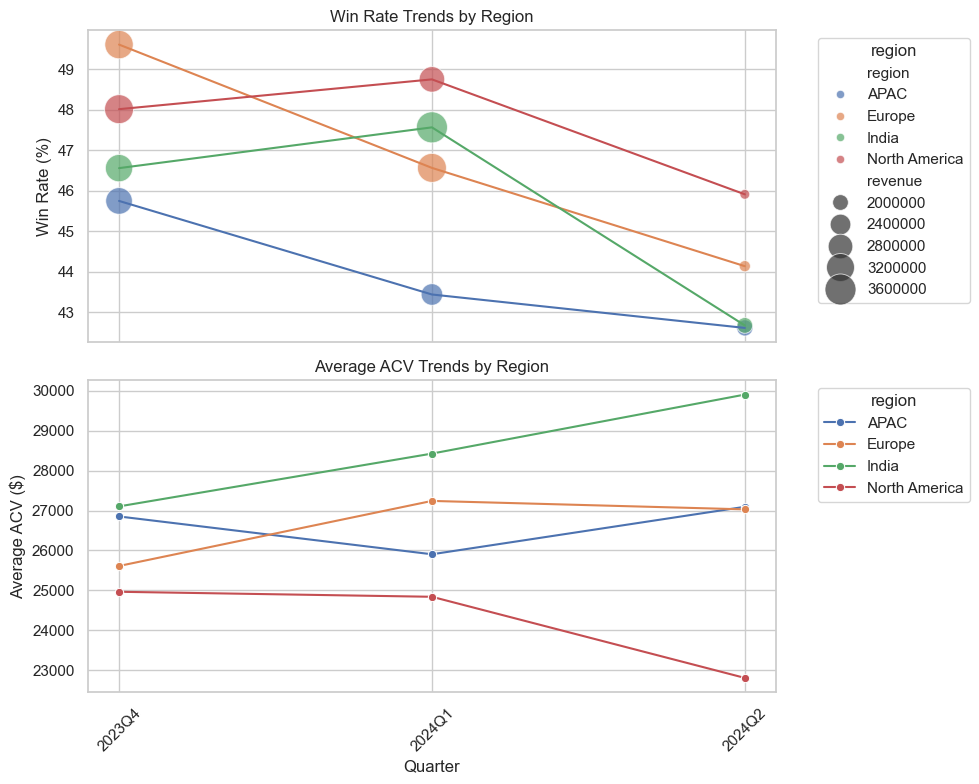

In [137]:
plot_win_rate_and_avg_acv_with_revenue(segment_tables["region"], "region")

#### Insights
1. Win Rate Trends:
- All regions show a slight decline in win rate over the past two quarters.
- India’s win rate has dropped from ~46.6% in 2023Q4 to ~42.7% in 2024Q2.
  
2. Average ACV / Revenue:
- Despite the lower win rate, India consistently has the highest average deal value (ACV) among all regions.
- This means each deal closed in India contributes more revenue than similar deals elsewhere.

3. Opportunity Identification:
- Even with fewer deals being won, the revenue impact from India remains significant.
- Regions with higher win rates but lower ACV (like North America or Europe) are contributing smaller revenue per deal.

#### Industry wise segmentation

In [135]:
segment_tables['industry']

succesful_deals   win_rate       avg_acv
closed_year_and_quarter industry                                            
2023Q4                  Ecommerce                99  45.412844  26863.733945
                        EdTech                   90  45.685279  27355.543147
                        FinTech                  97  51.052632  25417.436842
                        HealthTech              109  50.230415  25262.410138
                        SaaS                     93  45.365854  25576.687805
2024Q1                  Ecommerce                99  47.826087  25014.584541
                        EdTech                   90  44.334975  27386.413793
                        FinTech                  97  50.785340  28282.664921
                        HealthTech               89  45.641026  27020.246154
                        SaaS                     87  44.845361  25801.448454
2024Q2                  Ecommerce                49  41.880342  23604.094017
                        EdTech                   51  39.534884  30674.945736
                        FinTech                  56  44.094488  26060.330709
                        HealthTech               60  46.153846  22884.376923
                        SaaS                     63  47.014925  29895.671642

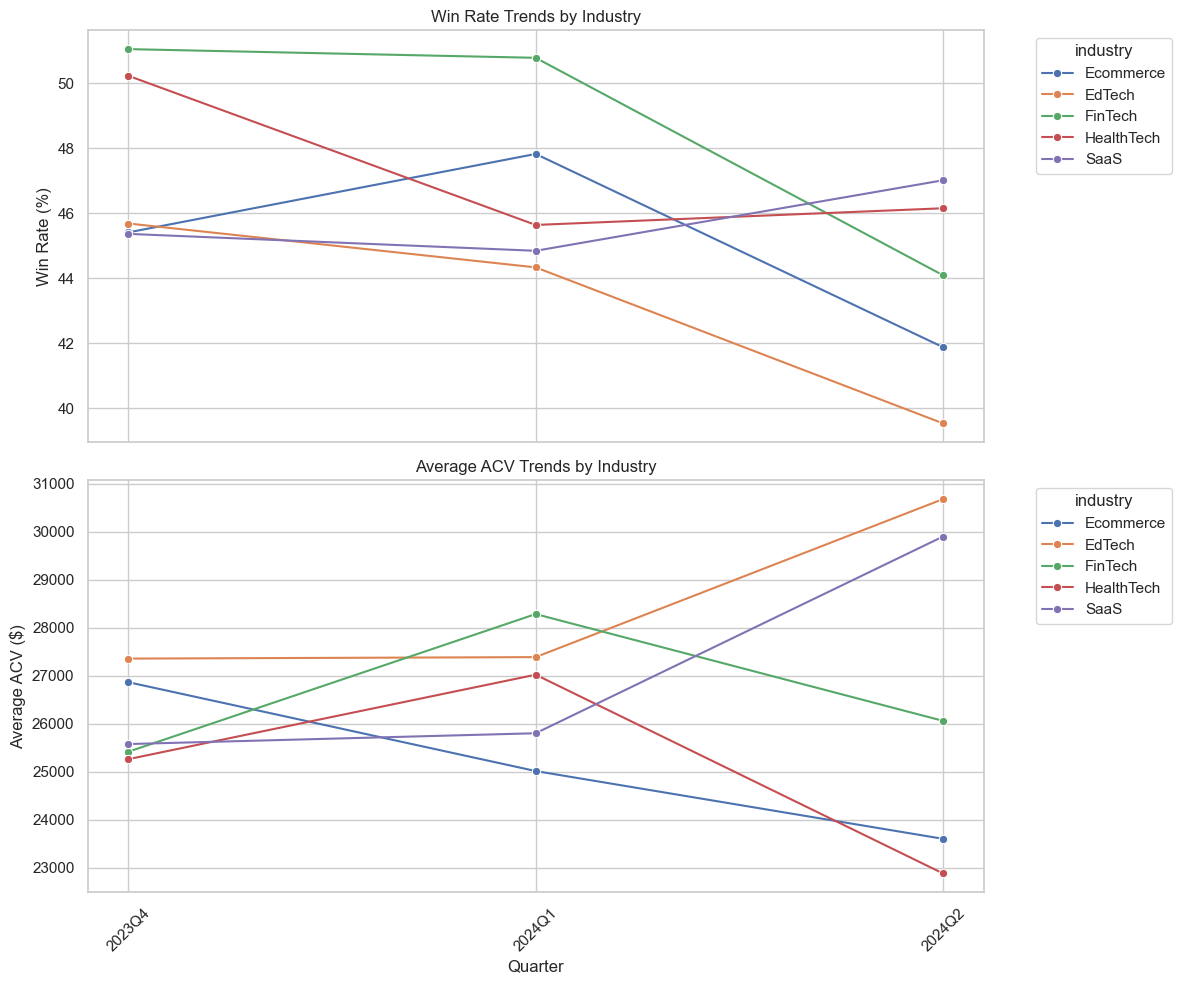

In [138]:
plot_win_rate_and_avg_acv(segment_tables["industry"], "industry")

#### Insights
1. Win Rate Trends:
- Most industries show a decline in win rate from 2023Q4 to 2024Q2.
- FinTech dropped from ~51.1% in 2023Q4 to ~44.1% in 2024Q2.
- SaaS is the only industry showing recovery in Q2 (~47.0%) after a dip in Q1.
  
2. Average ACV / Revenue:
- EdTech and SaaS show strong ACV growth, with EdTech reaching ~30.7K in 2024Q2.
- HealthTech and Ecommerce saw ACV decline in Q2.
- Higher ACV in Q2 (especially EdTech & SaaS) helps offset lower win rates.

3. Opportunity Identification:
- SaaS stands out with improving win rate and rising ACV in Q2.
- EdTech has high deal value but weakening conversion — sales efficiency opportunity.
- FinTech needs attention due to sharp win-rate decline despite solid ACV

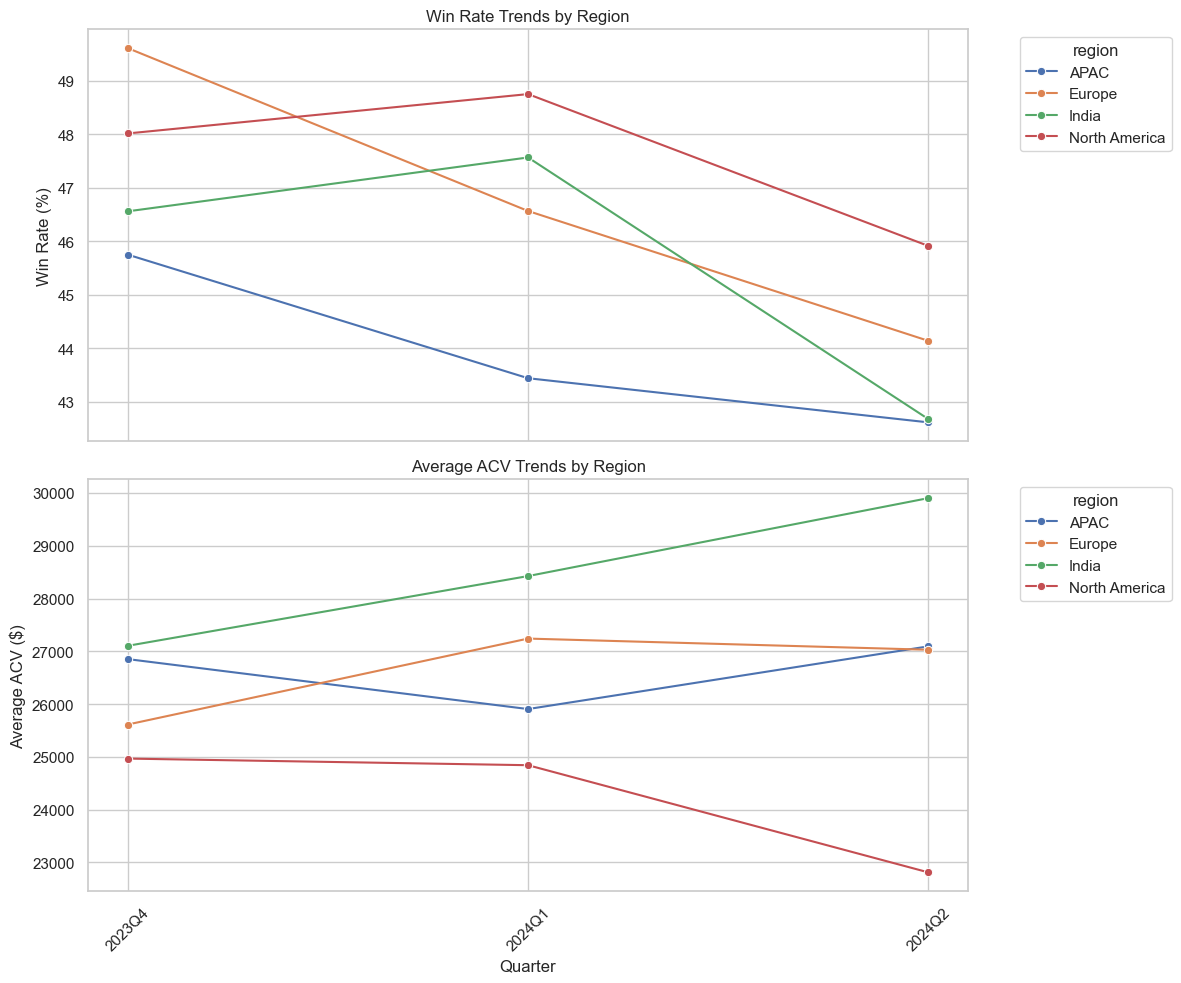

In [81]:
plot_win_rate_and_avg_acv(segment_tables["region"], "region")

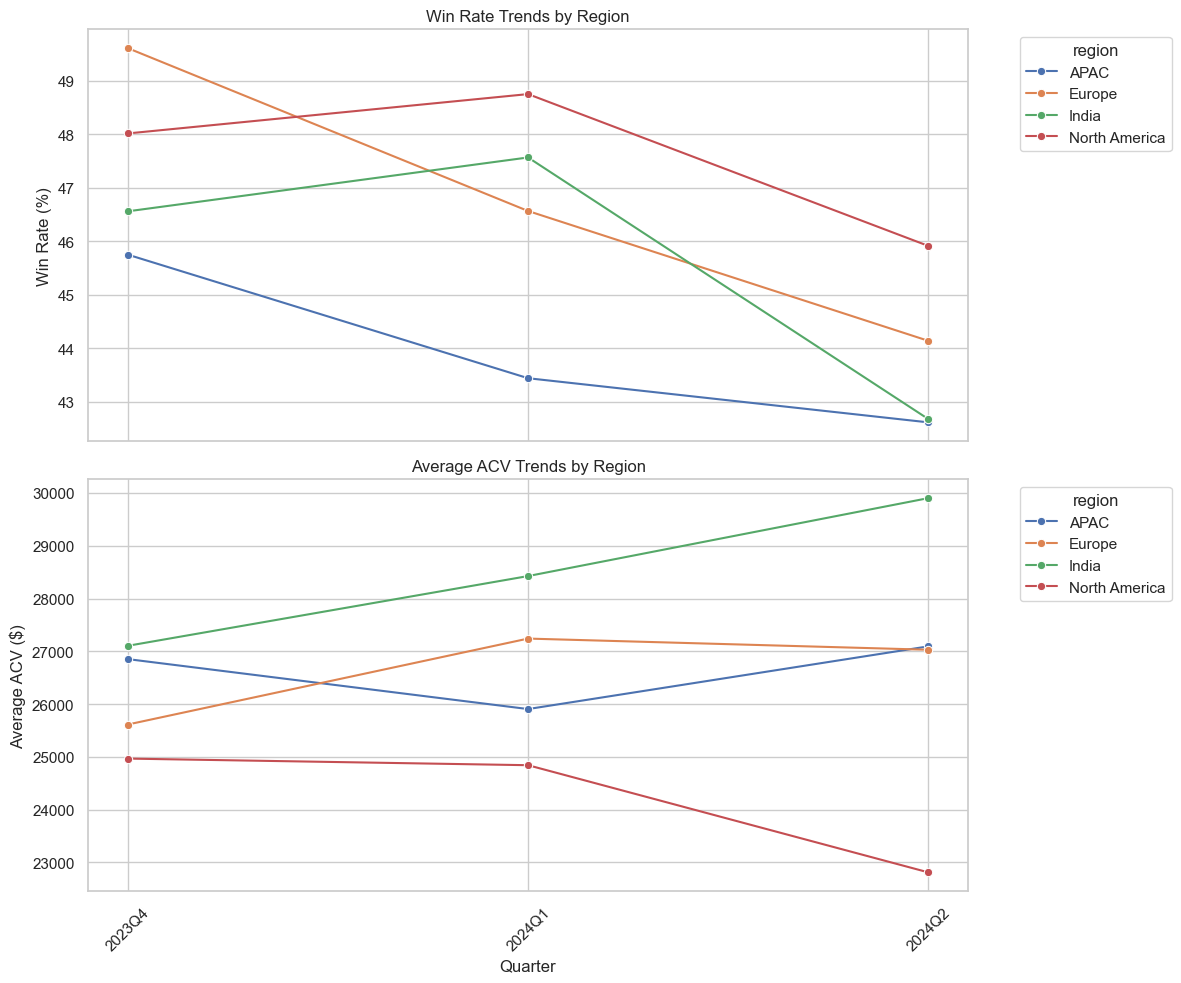

In [82]:
plot_win_rate_and_avg_acv(segment_tables["region"], "region")

In [46]:
df_grouped_deal_stage = (
    df.groupby(["closed_year_and_quarter", "deal_stage"])
      .agg(
          deals=("deal_id", "count"),
          win_rate=("is_won", "mean"),
          total_acv=("deal_amount", "sum"),
          avg_acv=("deal_amount", "mean"),
      )
      .reset_index()
).tail(15)

df_grouped_deal_stage

,closed_year_and_quarter,deal_stage,deals,win_rate,total_acv,avg_acv
15,2023Q4,Closed,219,0.515982,6257262,28571.972603
16,2023Q4,Demo,209,0.468900,5492144,26278.200957
17,2023Q4,Negotiation,196,0.505102,4610040,23520.612245
18,2023Q4,Proposal,211,0.445498,5265674,24955.800948
19,2023Q4,Qualified,192,0.437500,5174693,26951.526042
20,2024Q1,Closed,189,0.507937,5230063,27672.291005
21,2024Q1,Demo,218,0.454128,5730310,26285.825688
22,2024Q1,Negotiation,189,0.444444,5517826,29194.846561
23,2024Q1,Proposal,208,0.461538,4611668,22171.480769
24,2024Q1,Qualified,186,0.467742,5324012,28623.720430


In [72]:
stage_win_rate = (
    df.groupby("deal_stage")
      .agg(
          deals=("deal_id", "count"),
          win_rate=("is_won", "mean"),
          avg_cycle=("sales_cycle_days", "mean")
      )
      .assign(win_rate=lambda x: x["win_rate"] * 100)
      .sort_values("avg_cycle")
)

stage_win_rate


,deals,win_rate,avg_cycle
deal_stage,,,
Proposal,1004,44.820717,62.371514
Negotiation,990,46.565657,63.198990
Closed,993,46.727090,63.543807
Demo,1034,45.744681,63.545455
Qualified,950,42.105263,64.743158


In [38]:

quarterly_metrics = (
    df.groupby(["closed_year_and_quarter", 'deal_stage'])
      .agg(
          deals=("deal_id", "count"),
          win_rate=("is_won", "mean"),
          total_acv=("deal_amount", "sum"),
          avg_acv=("deal_amount", "mean"),
          avg_cycle=("sales_cycle_days", "mean")
      )
      # .reset_index()
)

quarterly_metrics["win_rate"] *= 100

# quarterly_metrics["late_stage_loss_rate"] = (
#     df[df["deal_stage"].isin(["Proposal", "Negotiation"])]
#       .groupby("closed_year_and_quarter")["is_won"]
#       .apply(lambda x: 1 - x.mean())
#       .values
# )

quarterly_metrics.sort_values("closed_year_and_quarter").tail(15)

deals   win_rate  total_acv  \
closed_year_and_quarter deal_stage                                 
2023Q4                  Closed         219  51.598174    6257262   
                        Demo           209  46.889952    5492144   
                        Negotiation    196  50.510204    4610040   
                        Proposal       211  44.549763    5265674   
                        Qualified      192  43.750000    5174693   
2024Q1                  Qualified      186  46.774194    5324012   
                        Proposal       208  46.153846    4611668   
                        Demo           218  45.412844    5730310   
                        Closed         189  50.793651    5230063   
                        Negotiation    189  44.444444    5517826   
2024Q2                  Proposal       114  39.473684    2602617   
                        Closed         139  43.165468    3763945   
                        Demo           131  45.038168    4056142   
                        Negotiation    129  44.961240    3670351   
                        Qualified      124  45.967742    2916343   

                                          avg_acv  avg_cycle  
closed_year_and_quarter deal_stage                            
2023Q4                  Closed       28571.972603  66.136986  
                        Demo         26278.200957  62.440191  
                        Negotiation  23520.612245  61.469388  
                        Proposal     24955.800948  58.350711  
                        Qualified    26951.526042  65.171875  
2024Q1                  Qualified    28623.720430  66.010753  
                        Proposal     22171.480769  62.990385  
                        Demo         26285.825688  62.128440  
                        Closed       27672.291005  63.153439  
                        Negotiation  29194.846561  61.629630  
2024Q2                  Proposal     22829.973684  83.842105  
                        Closed       27078.741007  77.899281  
                        Demo         30962.916031  82.106870  
                        Negotiation  28452.333333  83.069767  
                        Qualified    23518.895161  78.137097

In [19]:
df[df["deal_stage"].isin(["Proposal", "Negotiation"])] \
    .groupby("closed_year_and_quarter")["is_won"] \
    .apply(lambda x: 1 - x.mean()).values

array([0.55172414, 0.52657005, 0.55154639, 0.52579853, 0.5465995 ,
       0.57613169])

In [7]:
df['deal_stage'].value_counts()

deal_stage
Demo           1034
Proposal       1004
Closed          993
Negotiation     990
Qualified       950
Name: count, dtype: int64

In [22]:
df[df["deal_stage"].isin(["Qualified", "Closed"])]

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome,created_month,created_quarter,created_year,created_year_and_quarter,created_weekday,closed_month,closed_quarter,closed_year,closed_year_and_quarter,closed_weekday,sales_cycle_bucket,is_won,acv_bucket
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won,11,4,2023,2023Q4,4,12,4,2023,2023Q4,4,2-4w,1,Low
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won,1,1,2023,2023Q1,1,1,1,2023,2023Q1,4,<2w,1,Low
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost,2,1,2024,2024Q1,3,5,2,2024,2024Q2,6,2-3m,0,Very High
9,D00010,2023-10-26,2023-12-23,rep_4,HealthTech,Europe,Enterprise,Referral,Qualified,3133,58,Won,10,4,2023,2023Q4,3,12,4,2023,2023Q4,5,1-2m,1,Low
10,D00011,2023-11-02,2023-11-17,rep_1,FinTech,APAC,Enterprise,Partner,Closed,15668,15,Won,11,4,2023,2023Q4,3,11,4,2023,2023Q4,4,2-4w,1,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,D04986,2023-03-03,2023-06-03,rep_14,EdTech,North America,Core,Outbound,Qualified,19196,92,Lost,3,1,2023,2023Q1,4,6,2,2023,2023Q2,5,3m+,0,High
4992,D04993,2023-01-01,2023-01-29,rep_19,Ecommerce,North America,Pro,Partner,Closed,5416,28,Lost,1,1,2023,2023Q1,6,1,1,2023,2023Q1,6,2-4w,0,Low
4994,D04995,2024-02-12,2024-03-16,rep_14,SaaS,Europe,Core,Referral,Qualified,13345,33,Lost,2,1,2024,2024Q1,0,3,1,2024,2024Q1,5,1-2m,0,Mid
4995,D04996,2023-10-17,2023-12-03,rep_13,Ecommerce,North America,Enterprise,Partner,Closed,2586,47,Lost,10,4,2023,2023Q4,1,12,4,2023,2023Q4,6,1-2m,0,Low


In [30]:
stage_counts = (
    df.pivot_table(
        index="closed_year_and_quarter",
        columns="deal_stage",
        values="deal_id",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)
stage_counts

deal_stage,closed_year_and_quarter,Closed,Demo,Negotiation,Proposal,Qualified
0,2023Q1,62,66,74,71,55
1,2023Q2,173,197,219,195,189
2,2023Q3,211,213,183,205,204
3,2023Q4,219,209,196,211,192
4,2024Q1,189,218,189,208,186
5,2024Q2,139,131,129,114,124


In [40]:
df_grouped_deal_stage = (
    df.groupby("deal_stage")
      .agg(
          deals=("deal_id", "count"),
          win_rate=("is_won", "mean"),
          total_acv=("deal_amount", "sum"),
          avg_acv=("deal_amount", "mean"),
          avg_cycle=("sales_cycle_days", "mean"),
      )
      .reset_index()
)
df_grouped_deal_stage

,deal_stage,deals,win_rate,total_acv,avg_acv,avg_cycle
0,Closed,993,0.467271,27005257,27195.626385,63.543807
1,Demo,1034,0.457447,26949955,26063.786267,63.545455
2,Negotiation,990,0.465657,26237223,26502.245455,63.198990
3,Proposal,1004,0.448207,25064037,24964.180279,62.371514
4,Qualified,950,0.421053,25436609,26775.377895,64.743158


In [31]:
# Base quarterly metrics
quarterly_metrics = (
    df.groupby("closed_year_and_quarter")
      .agg(
          deals=("deal_id", "count"),
          win_rate=("is_won", "mean"),
          total_acv=("deal_amount", "sum"),
          avg_acv=("deal_amount", "mean"),
          avg_cycle=("sales_cycle_days", "mean"),
      )
      .reset_index()
)

# Convert win rate to %
quarterly_metrics["win_rate"] *= 100


# ---- Deal stage counts per quarter ----
stage_counts = (
    df.pivot_table(
        index="closed_year_and_quarter",
        columns="deal_stage",
        values="deal_id",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)

# Optional: flatten column index (if needed)
stage_counts.columns.name = None


# ---- Merge stage counts with main metrics ----
quarterly_metrics = quarterly_metrics.merge(
    stage_counts,
    on="closed_year_and_quarter",
    how="left"
)

# ---- Late stage loss rate (properly aligned) ----
late_stage_loss = (
    df[df["deal_stage"].isin(["Proposal", "Negotiation"])]
      .groupby("closed_year_and_quarter")["is_won"]
      .mean()
      .reset_index(name="late_stage_win_rate")
)

late_stage_loss["late_stage_loss_rate"] = 1 - late_stage_loss["late_stage_win_rate"]

quarterly_metrics = quarterly_metrics.merge(
    late_stage_loss[["closed_year_and_quarter", "late_stage_loss_rate"]],
    on="closed_year_and_quarter",
    how="left"
)

quarterly_metrics.sort_values("closed_year_and_quarter")


,closed_year_and_quarter,deals,win_rate,total_acv,avg_acv,avg_cycle,Closed,Demo,Negotiation,Proposal,Qualified,late_stage_loss_rate
0,2023Q1,328,44.512195,7689967,23445.021341,35.795732,62,66,74,71,55,0.551724
1,2023Q2,973,45.015416,24880389,25570.800617,61.382323,173,197,219,195,189,0.526570
2,2023Q3,1016,42.814961,27899635,27460.270669,64.538386,211,213,183,205,204,0.551546
3,2023Q4,1027,47.517040,26799813,26095.241480,62.713729,219,209,196,211,192,0.525799
4,2024Q1,990,46.666667,26413879,26680.685859,63.139394,189,218,189,208,186,0.546599
5,2024Q2,637,43.799058,17009398,26702.351648,80.921507,139,131,129,114,124,0.576132


In [26]:
df

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome,created_month,created_quarter,created_year,created_year_and_quarter,created_weekday,closed_month,closed_quarter,closed_year,closed_year_and_quarter,closed_weekday,sales_cycle_bucket,is_won,acv_bucket
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won,11,4,2023,2023Q4,4,12,4,2023,2023Q4,4,2-4w,1,Low
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won,1,1,2023,2023Q1,1,1,1,2023,2023Q1,4,<2w,1,Low
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost,10,4,2023,2023Q4,6,12,4,2023,2023Q4,6,1-2m,0,Mid
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won,7,3,2023,2023Q3,4,8,3,2023,2023Q3,2,2-4w,1,Low
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost,2,1,2024,2024Q1,3,5,2,2024,2024Q2,6,2-3m,0,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,D04996,2023-10-17,2023-12-03,rep_13,Ecommerce,North America,Enterprise,Partner,Closed,2586,47,Lost,10,4,2023,2023Q4,1,12,4,2023,2023Q4,6,1-2m,0,Low
4996,D04997,2023-11-11,2023-12-09,rep_20,FinTech,APAC,Core,Referral,Closed,10589,28,Lost,11,4,2023,2023Q4,5,12,4,2023,2023Q4,5,2-4w,0,Mid
4997,D04998,2023-10-19,2023-10-27,rep_24,FinTech,North America,Core,Inbound,Negotiation,57434,8,Won,10,4,2023,2023Q4,3,10,4,2023,2023Q4,4,<2w,1,Very High
4998,D04999,2023-03-12,2023-05-18,rep_21,SaaS,APAC,Enterprise,Inbound,Proposal,50717,67,Won,3,1,2023,2023Q1,6,5,2,2023,2023Q2,3,2-3m,1,Very High
